In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ripser import ripser
from persim import plot_diagrams
from fastdtw import fastdtw
from numpy.linalg import norm
from tqdm import tqdm  
from scipy.stats import wasserstein_distance

In [ ]:
# 定义滑动窗口嵌入的函数
def time_delay_embedding(series, window_size=21, lag=1):
    """
    对单个时间序列进行滑动窗口重构。
    返回形状为 (N - (window_size-1)*lag, window_size) 的矩阵。
    """
    N = len(series)
    M = N - (window_size - 1) * lag
    if M <= 0:
        raise ValueError("时间序列太短，无法重构")

    embedded = np.empty((M, window_size))
    for i in range(M):
        embedded[i, :] = series[i:(i + window_size * lag):lag]
    return embedded

window_size = 21  # 滑动窗口长度
lag = 1           # 延迟步长

### 1.使用Parkinson Volatility（vol）——Wasserstein Distance（wass）来开展拓扑数据分析

In [ ]:
# === 1. 读取 Excel 文件 ===
file_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/加密货币市场规模前10资产波动率.xlsx"
df = pd.read_excel(file_path)

# === 2. 时间列处理 ===
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')


In [27]:
# === 4. 滑动窗口嵌入 ===
df.columns = ['ETH', 'BTC', 'XRP', 'USDT', 'USDC', 'BNB', 'DOGE', 'ADA', 'TRX', 'SOL']
embedded_dict = {}

window_size = 21  # 滑动窗口长度
lag = 1           # 延迟步长

for coin in df.columns:
    data = df[coin].values
    embedded_dict[coin] = time_delay_embedding(data, window_size, lag)
    # print(f"{coin}: {embedded_dict[coin].shape}")

# 查看 ETH 的重构矩阵前3行
# print(pd.DataFrame(embedded_dict['ETH'][:3, :]))
coins = df.columns 
embedded_dict = {coin: time_delay_embedding(df[coin].values, window_size, lag) for coin in coins}

# 检查维度是否一致
for c, arr in embedded_dict.items():
    print(f"{c}: {arr.shape}")

ETH: (1854, 21)
BTC: (1854, 21)
XRP: (1854, 21)
USDT: (1854, 21)
USDC: (1854, 21)
BNB: (1854, 21)
DOGE: (1854, 21)
ADA: (1854, 21)
TRX: (1854, 21)
SOL: (1854, 21)


In [49]:
# === 5. 计算Wasserstein distance ===
n_coins = len(coins)
n_time = embedded_dict[coins[0]].shape[0]  # 有效窗口数量

# 存放所有时刻的相似度矩阵
similarity_matrices = []

for t in range(n_time):
    # 初始化 10x10 矩阵
    dist_mat = np.zeros((n_coins, n_coins))
    
    # 两两计算Wasserstein距离
    for i in range(n_coins):
        for j in range(i+1, n_coins):
            d = wasserstein_distance(embedded_dict[coins[i]][t, :],
                                     embedded_dict[coins[j]][t, :])
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    
    # 存储该时刻的矩阵
    similarity_matrices.append(dist_mat)

# 输出矩阵的数据结构
print(f"✅ 共生成 {len(similarity_matrices)} 个相似度矩阵，每个形状为 {similarity_matrices[0].shape}")

save_dir = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/vol_wasserstein_similarity"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "vol_wasserstein_similarity.npy"), similarity_matrices)
print(f"✅ 已保存 Wasserstein 相似度矩阵序列到 {save_dir}")

✅ 共生成 1853 个相似度矩阵，每个形状为 (10, 10)
✅ 已保存 Wasserstein 相似度矩阵序列到 /Users/jane/Documents/202511吾-Systems/3.Data_systems/vol_wasserstein_similarity


In [ ]:
# === 6. TDA指标的计算（VR filtration） ===

# === 假设你已有 similarity_matrices ===
# similarity_matrices.shape == (1853, 10, 10)
similarity_matrices = np.array(similarity_matrices)

n_time = similarity_matrices.shape[0]
# === 输出目录 ===
save_dir = "/Users/jane/Documents/吾-Systems/systems加密货币数据/TDA_results_vol_wasserstein"
os.makedirs(save_dir, exist_ok=True)

def betti_numbers(diagrams, thresholds):
    """计算不同ε阈值下的Betti数"""
    betti_0, betti_1 = [], []
    for eps in thresholds:
        b0 = np.sum((diagrams[0][:, 0] <= eps) & (diagrams[0][:, 1] > eps))
        b1 = np.sum((diagrams[1][:, 0] <= eps) & (diagrams[1][:, 1] > eps))
        betti_0.append(b0)
        betti_1.append(b1)
    return np.array(betti_0), np.array(betti_1)

def persistent_entropy(diagram):
    """计算持久熵"""
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]
    if len(lifetimes) == 0:
        return 0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p))

# === 参数设置 ===
n_time = similarity_matrices.shape[0]
epsilons = np.linspace(0, np.nanmax(similarity_matrices), 50)  # 50个过滤阈值

# === 存储容器 ===
betti0_series = np.zeros((n_time, len(epsilons)))
betti1_series = np.zeros((n_time, len(epsilons)))
entropy_series = np.zeros(n_time)

# === 主循环 ===
for t in range(n_time):
    dist_mat = similarity_matrices[t]
    dist_mat = np.nan_to_num(dist_mat)
    dist_mat = (dist_mat + dist_mat.T) / 2
    np.fill_diagonal(dist_mat, 0)
    
    # === 持久同调计算 ===
    result = ripser(dist_mat, distance_matrix=True, maxdim=1)
    diagrams = result['dgms']
    
    # === 保存生灭矩阵 ===
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H0.npy"), diagrams[0])
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H1.npy"), diagrams[1])
    
    # === 绘制并保存持久图 ===
    plt.figure(figsize=(4, 4))
    plot_diagrams(diagrams, show=False)
    plt.title(f"Persistence Diagram (t={t})")
    plt.savefig(os.path.join(save_dir, f"persistence_diagram_t{t:04d}.png"),
                dpi=300, bbox_inches="tight")
    plt.close()
    
    # === Betti 曲线计算 ===
    b0, b1 = betti_numbers(diagrams, epsilons)
    betti0_series[t, :] = b0
    betti1_series[t, :] = b1
    
    # === 持久熵（β1层） ===
    entropy_series[t] = persistent_entropy(diagrams[1])
    
    # === 进度反馈 ===
    if t % 100 == 0:
        print(f"已完成 {t}/{n_time} 个时间窗口...")

print("✅ 已完成所有 1853 个矩阵的 VR 复形过滤、持久特征计算与图像保存。")

# === 保存总体结果 ===
np.savez(os.path.join(save_dir, "VR_summary_results.npz"),
         epsilons=epsilons,
         betti0_series=betti0_series,
         betti1_series=betti1_series,
         entropy_series=entropy_series)

已完成 0/1854 个时间窗口...
已完成 100/1854 个时间窗口...
已完成 200/1854 个时间窗口...
已完成 300/1854 个时间窗口...
已完成 400/1854 个时间窗口...
已完成 500/1854 个时间窗口...
已完成 600/1854 个时间窗口...
已完成 700/1854 个时间窗口...
已完成 800/1854 个时间窗口...
已完成 900/1854 个时间窗口...
已完成 1000/1854 个时间窗口...
已完成 1100/1854 个时间窗口...
已完成 1200/1854 个时间窗口...
已完成 1300/1854 个时间窗口...
已完成 1400/1854 个时间窗口...
已完成 1500/1854 个时间窗口...
已完成 1600/1854 个时间窗口...
已完成 1700/1854 个时间窗口...
已完成 1800/1854 个时间窗口...
✅ 已完成所有 1853 个矩阵的 VR 复形过滤、持久特征计算与图像保存。


/opt/anaconda3/envs/topo_env_py311/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/anaconda3/envs/topo_env_py311/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])


### 2.使用市场价格的收益率（log）—— Wasserstein Distance（wass）来开展拓扑数据分析

In [35]:
# === 1. 读取数据 ===
file_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/加密货币市场规模前10资产价格.xlsx"
df = pd.read_excel(file_path) 
df = df.select_dtypes(include=[float, int])
# 假设 df 已经加载，并以日期为索引
df.columns = ['ETH', 'BTC', 'XRP', 'USDT', 'USDC', 'BNB', 'DOGE', 'ADA', 'TRX', 'SOL']

In [37]:
# 计算收益率
# === 计算对数收益率 ===
df_ret = np.log(df / df.shift(1))
df_ret = df_ret.dropna()
# print(df_ret.head())

In [39]:

window_size = 21  # 滑动窗口长度
lag = 1           # 延迟步长


# === 对每个币种进行重构 ===
embedded_dict = {}

for coin in df_ret .columns:
    data = df_ret [coin].values
    embedded_dict[coin] = time_delay_embedding(data, window_size, lag)
    print(f"{coin}: {embedded_dict[coin].shape}")

ETH: (1853, 21)
BTC: (1853, 21)
XRP: (1853, 21)
USDT: (1853, 21)
USDC: (1853, 21)
BNB: (1853, 21)
DOGE: (1853, 21)
ADA: (1853, 21)
TRX: (1853, 21)
SOL: (1853, 21)


In [46]:

# 假设 df 是之前加载的加密货币价格表，日期为索引
coins = df_ret .columns.tolist()
window_size = 21
lag = 1

embedded_dict = {coin: time_delay_embedding(df_ret[coin].values, window_size, lag) for coin in coins}
n_coins = len(coins)
n_time = embedded_dict[coins[0]].shape[0]  # 有效窗口数量

# 存放所有时刻的相似度矩阵
similarity_matrices = []

for t in range(n_time):
    # 初始化 10x10 矩阵
    dist_mat = np.zeros((n_coins, n_coins))
    
    # 两两计算Wasserstein距离
    for i in range(n_coins):
        for j in range(i+1, n_coins):
            d = wasserstein_distance(embedded_dict[coins[i]][t, :],
                                     embedded_dict[coins[j]][t, :])
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    
    # 存储该时刻的矩阵
    similarity_matrices.append(dist_mat)

print(f"✅ 共生成 {len(similarity_matrices)} 个相似度矩阵，每个形状为 {similarity_matrices[0].shape}")


✅ 共生成 1853 个相似度矩阵，每个形状为 (10, 10)


In [50]:
save_dir = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/log_wasserstein_similarity"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "log_wasserstein_similarity.npy"), similarity_matrices)
print(f"✅ 已保存 Wasserstein 相似度矩阵序列到 {save_dir}")

✅ 已保存 Wasserstein 相似度矩阵序列到 /Users/jane/Documents/202511吾-Systems/3.Data_systems/log_wasserstein_similarity


In [ ]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
import os

# === 假设你已有 similarity_matrices ===
# similarity_matrices.shape == (1853, 10, 10)

# === 输出目录 ===
save_dir = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_log_wasserstein"
os.makedirs(save_dir, exist_ok=True)

def betti_numbers(diagrams, thresholds):
    """计算不同ε阈值下的Betti数"""
    betti_0, betti_1 = [], []
    for eps in thresholds:
        b0 = np.sum((diagrams[0][:, 0] <= eps) & (diagrams[0][:, 1] > eps))
        b1 = np.sum((diagrams[1][:, 0] <= eps) & (diagrams[1][:, 1] > eps))
        betti_0.append(b0)
        betti_1.append(b1)
    return np.array(betti_0), np.array(betti_1)

def persistent_entropy(diagram):
    """计算持久熵"""
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]
    if len(lifetimes) == 0:
        return 0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p))

# === 参数设置 ===
import numpy as np
similarity_matrices = np.array(similarity_matrices)
n_time = similarity_matrices.shape[0]

epsilons = np.linspace(0, np.nanmax(similarity_matrices), 50)  # 50个过滤阈值

# === 存储容器 ===
betti0_series = np.zeros((n_time, len(epsilons)))
betti1_series = np.zeros((n_time, len(epsilons)))
entropy_series = np.zeros(n_time)

# === 主循环 ===
for t in range(n_time):
    dist_mat = similarity_matrices[t]
    dist_mat = np.nan_to_num(dist_mat)
    dist_mat = (dist_mat + dist_mat.T) / 2
    np.fill_diagonal(dist_mat, 0)
    
    # === 持久同调计算 ===
    result = ripser(dist_mat, distance_matrix=True, maxdim=1)
    diagrams = result['dgms']
    
    # === 保存生灭矩阵 ===
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H0.npy"), diagrams[0])
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H1.npy"), diagrams[1])
    
    # === 绘制并保存持久图 ===
    plt.figure(figsize=(4, 4))
    plot_diagrams(diagrams, show=False)
    plt.title(f"Persistence Diagram (t={t})")
    plt.savefig(os.path.join(save_dir, f"persistence_diagram_t{t:04d}.png"),
                dpi=300, bbox_inches="tight")
    plt.close()
    
    # === Betti 曲线计算 ===
    b0, b1 = betti_numbers(diagrams, epsilons)
    betti0_series[t, :] = b0
    betti1_series[t, :] = b1
    
    # === 持久熵（β1层） ===
    entropy_series[t] = persistent_entropy(diagrams[1])
    
    # === 进度反馈 ===
    if t % 100 == 0:
        print(f"已完成 {t}/{n_time} 个时间窗口...")

print("✅ 已完成所有 1853 个矩阵的 VR 复形过滤、持久特征计算与图像保存。")

# === 保存总体结果 ===
np.savez(os.path.join(save_dir, "VR_summary_results.npz"),
         epsilons=epsilons,
         betti0_series=betti0_series,
         betti1_series=betti1_series,
         entropy_series=entropy_series)

已完成 0/1853 个时间窗口...
已完成 100/1853 个时间窗口...
已完成 200/1853 个时间窗口...
已完成 300/1853 个时间窗口...
已完成 400/1853 个时间窗口...
已完成 500/1853 个时间窗口...
已完成 600/1853 个时间窗口...
已完成 700/1853 个时间窗口...
已完成 800/1853 个时间窗口...
已完成 900/1853 个时间窗口...
已完成 1000/1853 个时间窗口...
已完成 1100/1853 个时间窗口...
已完成 1200/1853 个时间窗口...
已完成 1300/1853 个时间窗口...
已完成 1400/1853 个时间窗口...
已完成 1500/1853 个时间窗口...
已完成 1600/1853 个时间窗口...
已完成 1700/1853 个时间窗口...
已完成 1800/1853 个时间窗口...
✅ 已完成所有 1853 个矩阵的 VR 复形过滤、持久特征计算与图像保存。


### 3. 使用市场价格的收益率（log）——DTW来展开拓扑数据分析

In [ ]:
# === 1. 读取数据 ===
file_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/加密货币市场规模前10资产价格.xlsx"
df = pd.read_excel(file_path) 
df = df.select_dtypes(include=[float, int])
# 假设 df 已经加载，并以日期为索引
df.columns = ['ETH', 'BTC', 'XRP', 'USDT', 'USDC', 'BNB', 'DOGE', 'ADA', 'TRX', 'SOL']
# 计算收益率
# ===2. 计算对数收益率 ===
df_ret = np.log(df / df.shift(1))
df_ret = df_ret.dropna()


# ===3. 对每个币种进行重构 ===
embedded_dict = {}

for coin in df_ret .columns:
    data = df_ret [coin].values
    embedded_dict[coin] = time_delay_embedding(data, window_size, lag)
    print(f"{coin}: {embedded_dict[coin].shape}")


In [67]:

# 自定义距离函数（支持任意维度）
def vector_dist(u, v):
    u = np.ravel(np.array(u))
    v = np.ravel(np.array(v))
    return norm(u - v)

# 基本信息
coins = list(embedded_dict.keys())
n_coins = len(coins)
n_time = embedded_dict[coins[0]].shape[0]

# 存储每个时刻的相似度矩阵
similarity_matrices_dtw = []

print("开始计算每个时刻的 DTW 相似度矩阵...")

for t in tqdm(range(n_time)):
    dist_mat = np.zeros((n_coins, n_coins))
    
    # 两两币种之间计算 DTW
    for i in range(n_coins):
        for j in range(i + 1, n_coins):
            seq_i = embedded_dict[coins[i]][t, :]
            seq_j = embedded_dict[coins[j]][t, :]
            
            d, _ = fastdtw(seq_i, seq_j, dist=vector_dist)
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    
    similarity_matrices_dtw.append(dist_mat)

print(f"✅ 共生成 {len(similarity_matrices_dtw)} 个 DTW 距离矩阵，每个形状为 {similarity_matrices_dtw[0].shape}")

开始计算每个时刻的 DTW 相似度矩阵...


100%|██████████| 1853/1853 [01:05<00:00, 28.34it/s]

✅ 共生成 1853 个 DTW 距离矩阵，每个形状为 (10, 10)


In [70]:
output_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/log_DTW_similarity/log_DTW_similarity.npz"

np.savez(output_path,
         similarity_matrices=similarity_matrices_dtw,
         coins=coins)

print(f"✅ 已成功保存 DTW 相似矩阵：{output_path}")
print(f"  包含 {len(similarity_matrices_dtw)} 个矩阵，每个形状为 {similarity_matrices_dtw[0].shape}")

✅ 已成功保存 DTW 相似矩阵：/Users/jane/Documents/202511吾-Systems/3.Data_systems/log_DTW_similarity/log_DTW_similarity.npz
  包含 1853 个矩阵，每个形状为 (10, 10)


In [72]:
import numpy as np
import os
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

# === 1. 载入你的 DTW 相似矩阵 ===
data_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/log_DTW_similarity/log_DTW_similarity.npz"
data = np.load(data_path, allow_pickle=True)
similarity_matrices = data['similarity_matrices']
coins = data['coins']

print(f"✅ 已载入 DTW 相似矩阵: {similarity_matrices.shape} （{len(coins)}个币种）")

# === 2. 输出目录 ===
save_dir = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_log_DTW"
os.makedirs(save_dir, exist_ok=True)

# === 3. 辅助函数 ===
def betti_numbers(diagrams, thresholds):
    """计算不同 ε 阈值下的 Betti 数"""
    betti_0, betti_1 = [], []
    for eps in thresholds:
        b0 = np.sum((diagrams[0][:, 0] <= eps) & (diagrams[0][:, 1] > eps))
        b1 = np.sum((diagrams[1][:, 0] <= eps) & (diagrams[1][:, 1] > eps))
        betti_0.append(b0)
        betti_1.append(b1)
    return np.array(betti_0), np.array(betti_1)

def persistent_entropy(diagram):
    """计算持久熵"""
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]
    if len(lifetimes) == 0:
        return 0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p))

# === 4. 参数设置 ===
n_time = similarity_matrices.shape[0]
epsilons = np.linspace(0, np.nanmax(similarity_matrices), 50)

betti0_series = np.zeros((n_time, len(epsilons)))
betti1_series = np.zeros((n_time, len(epsilons)))
entropy_series = np.zeros(n_time)

# === 5. 主循环 ===
for t in range(n_time):
    dist_mat = similarity_matrices[t]
    dist_mat = np.nan_to_num(dist_mat)
    dist_mat = (dist_mat + dist_mat.T) / 2
    np.fill_diagonal(dist_mat, 0)

    # --- 持久同调计算 ---
    result = ripser(dist_mat, distance_matrix=True, maxdim=1)
    diagrams = result['dgms']

    # --- 保存生灭矩阵 ---
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H0.npy"), diagrams[0])
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H1.npy"), diagrams[1])

    # --- 绘制并保存持久图 ---
    plt.figure(figsize=(4, 4))
    plot_diagrams(diagrams, show=False)
    plt.title(f"Persistence Diagram (t={t})")
    plt.savefig(os.path.join(save_dir, f"persistence_diagram_t{t:04d}.png"),
                dpi=300, bbox_inches="tight")
    plt.close()

    # --- Betti 曲线计算 ---
    b0, b1 = betti_numbers(diagrams, epsilons)
    betti0_series[t, :] = b0
    betti1_series[t, :] = b1

    # --- 持久熵（β1层） ---
    entropy_series[t] = persistent_entropy(diagrams[1])

    if t % 100 == 0:
        print(f"进度: 已完成 {t}/{n_time} 个时间窗口...")

print("✅ 已完成所有矩阵的 VR 复形过滤、持久特征计算与图像保存。")

# === 6. 保存总体结果 ===
np.savez(os.path.join(save_dir, "VR_summary_results_DTW.npz"),
         epsilons=epsilons,
         betti0_series=betti0_series,
         betti1_series=betti1_series,
         entropy_series=entropy_series)

print("📁 已保存全部结果到 VR_summary_results_DTW.npz")

✅ 已载入 DTW 相似矩阵: (1853, 10, 10) （10个币种）
进度: 已完成 0/1853 个时间窗口...
进度: 已完成 100/1853 个时间窗口...
进度: 已完成 200/1853 个时间窗口...
进度: 已完成 300/1853 个时间窗口...
进度: 已完成 400/1853 个时间窗口...
进度: 已完成 500/1853 个时间窗口...
进度: 已完成 600/1853 个时间窗口...
进度: 已完成 700/1853 个时间窗口...
进度: 已完成 800/1853 个时间窗口...
进度: 已完成 900/1853 个时间窗口...
进度: 已完成 1000/1853 个时间窗口...
进度: 已完成 1100/1853 个时间窗口...
进度: 已完成 1200/1853 个时间窗口...
进度: 已完成 1300/1853 个时间窗口...
进度: 已完成 1400/1853 个时间窗口...
进度: 已完成 1500/1853 个时间窗口...
进度: 已完成 1600/1853 个时间窗口...
进度: 已完成 1700/1853 个时间窗口...
进度: 已完成 1800/1853 个时间窗口...
✅ 已完成所有矩阵的 VR 复形过滤、持久特征计算与图像保存。
📁 已保存全部结果到 VR_summary_results_DTW.npz


### 4. 使用Parkinson Volatility（vol）—— Wasserstein Distance（wass）来开展拓扑数据分析

In [79]:
# === 1) 读取“波动率”数据 ===
file_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/加密货币市场规模前10资产波动率.xlsx"
df = pd.read_excel(file_path)

# === 2. 时间列处理 ===
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# === 3. 对每个币种进行重构 ===
embedded_dict = {}

for coin in df.columns:
    data = df[coin].values
    embedded_dict[coin] = time_delay_embedding(data, window_size, lag)
    print(f"{coin}: {embedded_dict[coin].shape}")

# 查看 ETH 的重构矩阵前3行
# print(pd.DataFrame(embedded_dict['ETH'][:3, :]))

ETH: (1854, 21)
BTC: (1854, 21)
XRP: (1854, 21)
USDT: (1854, 21)
USDC: (1854, 21)
BNB: (1854, 21)
DOGE: (1854, 21)
ADA: (1854, 21)
TRX: (1854, 21)
SOL: (1854, 21)


In [80]:
def vector_dist(u, v):
    u = np.ravel(np.array(u))
    v = np.ravel(np.array(v))
    return norm(u - v)

# 基本信息
coins = list(embedded_dict.keys())
n_coins = len(coins)
n_time = embedded_dict[coins[0]].shape[0]

# 存储每个时刻的相似度矩阵
similarity_matrices_dtw = []

print("开始计算每个时刻的 DTW 相似度矩阵...")

for t in tqdm(range(n_time)):
    dist_mat = np.zeros((n_coins, n_coins))
    
    # 两两币种之间计算 DTW
    for i in range(n_coins):
        for j in range(i + 1, n_coins):
            seq_i = embedded_dict[coins[i]][t, :]
            seq_j = embedded_dict[coins[j]][t, :]
            
            d, _ = fastdtw(seq_i, seq_j, dist=vector_dist)
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    
    similarity_matrices_dtw.append(dist_mat)

print(f"✅ 共生成 {len(similarity_matrices_dtw)} 个 DTW 距离矩阵，每个形状为 {similarity_matrices_dtw[0].shape}")

开始计算每个时刻的 DTW 相似度矩阵...


100%|██████████| 1854/1854 [01:09<00:00, 26.74it/s]

✅ 共生成 1854 个 DTW 距离矩阵，每个形状为 (10, 10)


In [81]:
import numpy as np

output_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/vol_DTW_similarity/vol_DTW_similarity.npz"

np.savez(output_path,
         similarity_matrices=similarity_matrices_dtw,
         coins=coins)

print(f"✅ 已成功保存 DTW 相似矩阵：{output_path}")
print(f"  包含 {len(similarity_matrices_dtw)} 个矩阵，每个形状为 {similarity_matrices_dtw[0].shape}")

✅ 已成功保存 DTW 相似矩阵：/Users/jane/Documents/202511吾-Systems/3.Data_systems/vol_DTW_similarity/vol_DTW_similarity.npz
  包含 1854 个矩阵，每个形状为 (10, 10)


In [82]:


# === 1. 载入你的 DTW 相似矩阵 ===
data_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/vol_DTW_similarity/vol_DTW_similarity.npz"
data = np.load(data_path, allow_pickle=True)
similarity_matrices = data['similarity_matrices']
coins = data['coins']

print(f"✅ 已载入 DTW 相似矩阵: {similarity_matrices.shape} （{len(coins)}个币种）")

# === 2. 输出目录 ===
save_dir = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_vol_DTW"
os.makedirs(save_dir, exist_ok=True)

# === 3. 辅助函数 ===
def betti_numbers(diagrams, thresholds):
    """计算不同 ε 阈值下的 Betti 数"""
    betti_0, betti_1 = [], []
    for eps in thresholds:
        b0 = np.sum((diagrams[0][:, 0] <= eps) & (diagrams[0][:, 1] > eps))
        b1 = np.sum((diagrams[1][:, 0] <= eps) & (diagrams[1][:, 1] > eps))
        betti_0.append(b0)
        betti_1.append(b1)
    return np.array(betti_0), np.array(betti_1)

def persistent_entropy(diagram):
    """计算持久熵"""
    lifetimes = diagram[:, 1] - diagram[:, 0]
    lifetimes = lifetimes[lifetimes > 0]
    if len(lifetimes) == 0:
        return 0
    p = lifetimes / np.sum(lifetimes)
    return -np.sum(p * np.log(p))

# === 4. 参数设置 ===
n_time = similarity_matrices.shape[0]
epsilons = np.linspace(0, np.nanmax(similarity_matrices), 50)

betti0_series = np.zeros((n_time, len(epsilons)))
betti1_series = np.zeros((n_time, len(epsilons)))
entropy_series = np.zeros(n_time)

# === 5. 主循环 ===
for t in range(n_time):
    dist_mat = similarity_matrices[t]
    dist_mat = np.nan_to_num(dist_mat)
    dist_mat = (dist_mat + dist_mat.T) / 2
    np.fill_diagonal(dist_mat, 0)

    # --- 持久同调计算 ---
    result = ripser(dist_mat, distance_matrix=True, maxdim=1)
    diagrams = result['dgms']

    # --- 保存生灭矩阵 ---
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H0.npy"), diagrams[0])
    np.save(os.path.join(save_dir, f"birth_death_t{t:04d}_H1.npy"), diagrams[1])

    # --- 绘制并保存持久图 ---
    plt.figure(figsize=(4, 4))
    plot_diagrams(diagrams, show=False)
    plt.title(f"Persistence Diagram (t={t})")
    plt.savefig(os.path.join(save_dir, f"persistence_diagram_t{t:04d}.png"),
                dpi=300, bbox_inches="tight")
    plt.close()

    # --- Betti 曲线计算 ---
    b0, b1 = betti_numbers(diagrams, epsilons)
    betti0_series[t, :] = b0
    betti1_series[t, :] = b1

    # --- 持久熵（β1层） ---
    entropy_series[t] = persistent_entropy(diagrams[1])

    if t % 100 == 0:
        print(f"进度: 已完成 {t}/{n_time} 个时间窗口...")

print("✅ 已完成所有矩阵的 VR 复形过滤、持久特征计算与图像保存。")

# === 6. 保存总体结果 ===
np.savez(os.path.join(save_dir, "VR_summary_results_DTW.npz"),
         epsilons=epsilons,
         betti0_series=betti0_series,
         betti1_series=betti1_series,
         entropy_series=entropy_series)

print("📁 已保存全部结果到 VR_summary_results_DTW.npz")

✅ 已载入 DTW 相似矩阵: (1854, 10, 10) （10个币种）
进度: 已完成 0/1854 个时间窗口...
进度: 已完成 100/1854 个时间窗口...
进度: 已完成 200/1854 个时间窗口...
进度: 已完成 300/1854 个时间窗口...
进度: 已完成 400/1854 个时间窗口...
进度: 已完成 500/1854 个时间窗口...
进度: 已完成 600/1854 个时间窗口...
进度: 已完成 700/1854 个时间窗口...
进度: 已完成 800/1854 个时间窗口...
进度: 已完成 900/1854 个时间窗口...
进度: 已完成 1000/1854 个时间窗口...
进度: 已完成 1100/1854 个时间窗口...
进度: 已完成 1200/1854 个时间窗口...
进度: 已完成 1300/1854 个时间窗口...
进度: 已完成 1400/1854 个时间窗口...
进度: 已完成 1500/1854 个时间窗口...
进度: 已完成 1600/1854 个时间窗口...
进度: 已完成 1700/1854 个时间窗口...
进度: 已完成 1800/1854 个时间窗口...
✅ 已完成所有矩阵的 VR 复形过滤、持久特征计算与图像保存。
📁 已保存全部结果到 VR_summary_results_DTW.npz


/opt/anaconda3/envs/topo_env_py311/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/opt/anaconda3/envs/topo_env_py311/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])


### 汇总全部TDA特征

In [ ]:
# === 1. 文件路径 ===
path_vol_w  = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_vol_wasserstein/VR_summary_results.npz"
path_log_w  = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_log_wasserstein/VR_summary_results.npz"
path_log_dtw = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_log_DTW/VR_summary_results_DTW.npz"
path_vol_dtw = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_vol_DTW/VR_summary_results_DTW.npz"

# 读取工具
def load_npz(path, drop_first=False):
    d = np.load(path, allow_pickle=True)
    b0  = d["betti0_series"][1:, :] if drop_first else d["betti0_series"]
    b1  = d["betti1_series"][1:, :] if drop_first else d["betti1_series"]
    ent = d["entropy_series"][1:]   if drop_first else d["entropy_series"]
    eps = d["epsilons"]
    return b0, b1, ent, eps

# === 2. 加载 4 类结果 ===
vol_b0, vol_b1, vol_ent, vol_eps = load_npz(path_vol_w, drop_first=True)
log_b0, log_b1, log_ent, log_eps = load_npz(path_log_w, drop_first=False)
ldt_b0, ldt_b1, ldt_ent, ldt_eps = load_npz(path_log_dtw, drop_first=False)
vdt_b0, vdt_b1, vdt_ent, vdt_eps = load_npz(path_vol_dtw, drop_first=False)

# === 3. 自动对齐长度 ===
min_len = min(map(len, [vol_b0, log_b0, ldt_b0, vdt_b0]))

vol_b0, vol_b1, vol_ent = vol_b0[:min_len], vol_b1[:min_len], vol_ent[:min_len]
log_b0, log_b1, log_ent = log_b0[:min_len], log_b1[:min_len], log_ent[:min_len]
ldt_b0, ldt_b1, ldt_ent = ldt_b0[:min_len], ldt_b1[:min_len], ldt_ent[:min_len]
vdt_b0, vdt_b1, vdt_ent = vdt_b0[:min_len], vdt_b1[:min_len], vdt_ent[:min_len]

# === 4. 求 epsilon 维度均值 ===
vol_wass_betti0 = vol_b0.mean(axis=1)
vol_wass_betti1 = vol_b1.mean(axis=1)
vol_wass_entropy = vol_ent

log_wass_betti0 = log_b0.mean(axis=1)
log_wass_betti1 = log_b1.mean(axis=1)
log_wass_entropy = log_ent

log_dtw_betti0 = ldt_b0.mean(axis=1)
log_dtw_betti1 = ldt_b1.mean(axis=1)
log_dtw_entropy = ldt_ent

vol_dtw_betti0 = vdt_b0.mean(axis=1)
vol_dtw_betti1 = vdt_b1.mean(axis=1)
vol_dtw_entropy = vdt_ent

# === 5. 创建 Date 列 ===
start_date = pd.to_datetime("2020-08-21")   # ← 如需修改告诉我
date_series = start_date + pd.to_timedelta(np.arange(min_len), unit="D")

# === 6. 组装 DataFrame（统一命名） ===
df_merged = pd.DataFrame({
    "time_index": np.arange(min_len),
    "date": date_series,

    "vol_wass_betti0": vol_wass_betti0,
    "vol_wass_betti1": vol_wass_betti1,
    "vol_wass_entropy": vol_wass_entropy,

    "log_wass_betti0": log_wass_betti0,
    "log_wass_betti1": log_wass_betti1,
    "log_wass_entropy": log_wass_entropy,

    "log_dtw_betti0": log_dtw_betti0,
    "log_dtw_betti1": log_dtw_betti1,
    "log_dtw_entropy": log_dtw_entropy,

    "vol_dtw_betti0": vol_dtw_betti0,
    "vol_dtw_betti1": vol_dtw_betti1,
    "vol_dtw_entropy": vol_dtw_entropy
})

print(df_merged.head())
print(df_merged.shape)

# === 7. 保存 ===
out_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_merged_new.csv"
df_merged.to_csv(out_path, index=False)

print(f"✅ 已保存（含 Date 列）到:\n{out_path}")

   time_index       date  vol_wass_betti0  vol_wass_betti1  vol_wass_entropy  \
0           0 2020-08-21             1.26              0.0               0.0   
1           1 2020-08-22             1.24              0.0               0.0   
2           2 2020-08-23             1.22              0.0               0.0   
3           3 2020-08-24             1.26              0.0               0.0   
4           4 2020-08-25             1.28              0.0               0.0   

   log_wass_betti0  log_wass_betti1  log_wass_entropy  log_dtw_betti0  \
0             1.54              0.0               0.0            1.90   
1             1.62              0.0               0.0            1.94   
2             1.62              0.0               0.0            1.92   
3             1.72              0.0              -0.0            2.02   
4             1.64              0.0               0.0            1.96   

   log_dtw_betti1  log_dtw_entropy  vol_dtw_betti0  vol_dtw_betti1  \
0         

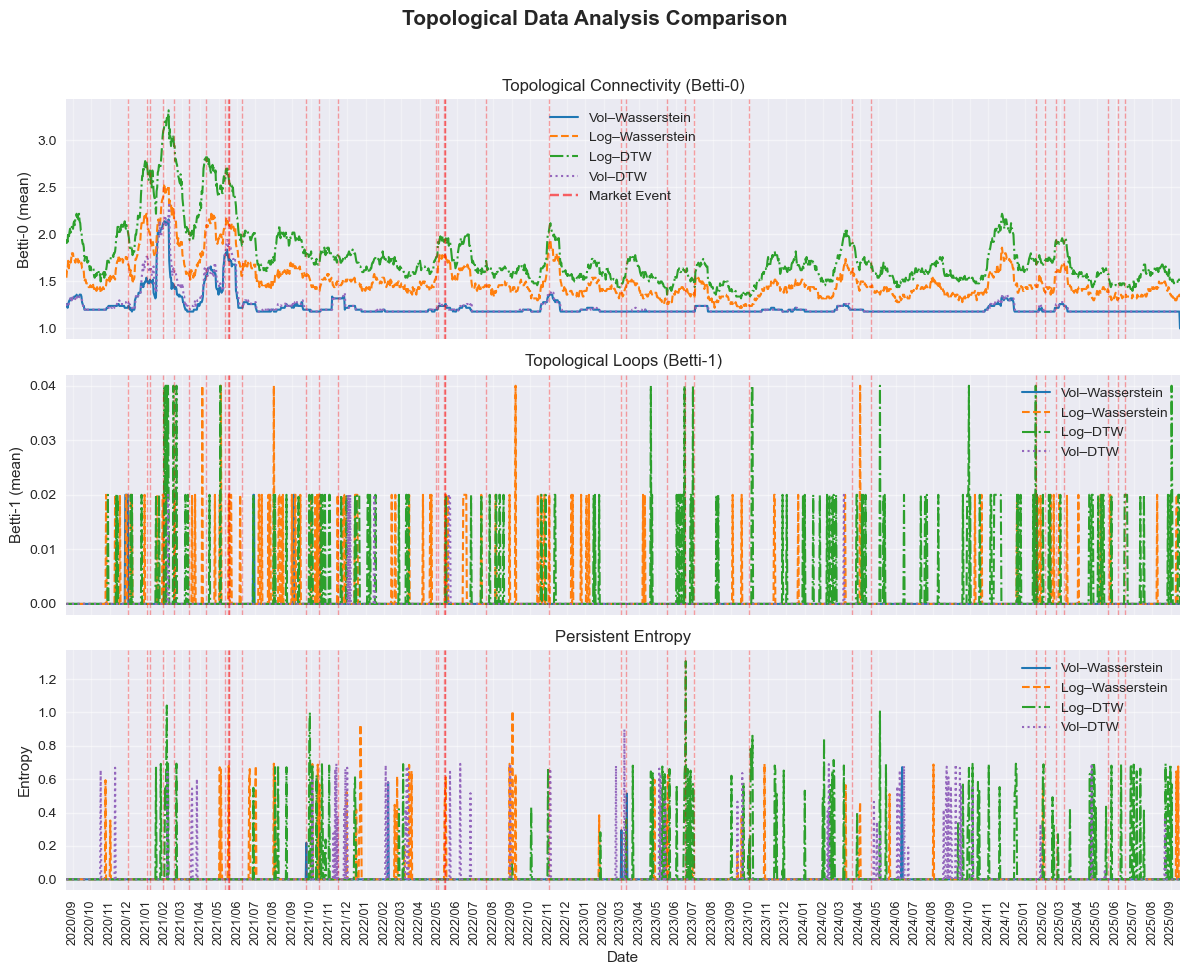

图已保存: /Users/jane/Documents/202511吾-Systems/4.Plot/Fig2-1_old.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# === 1. 读取新的 TDA + 日期 数据 ===
path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_merged_new.csv"
date_col = "date"

df_merged = pd.read_csv(path, parse_dates=[date_col])
x = df_merged[date_col]

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# ============================================
# 2) Betti-0
# ============================================
axes[0].plot(x, df_merged["vol_wass_betti0"], label="Vol–Wasserstein",
             color="tab:blue", linewidth=1.5)
axes[0].plot(x, df_merged["log_wass_betti0"], label="Log–Wasserstein",
             color="tab:orange", linestyle="--", linewidth=1.5)
axes[0].plot(x, df_merged["log_dtw_betti0"], label="Log–DTW",
             color="tab:green", linestyle="-.", linewidth=1.5)
axes[0].plot(x, df_merged["vol_dtw_betti0"], label="Vol–DTW",
             color="tab:purple", linestyle=":", linewidth=1.5)

axes[0].set_ylabel("Betti-0 (mean)")
axes[0].set_title("Topological Connectivity (Betti-0)")
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# ============================================
# 3) Betti-1
# ============================================
axes[1].plot(x, df_merged["vol_wass_betti1"], label="Vol–Wasserstein",
             color="tab:blue", linewidth=1.5)
axes[1].plot(x, df_merged["log_wass_betti1"], label="Log–Wasserstein",
             color="tab:orange", linestyle="--", linewidth=1.5)
axes[1].plot(x, df_merged["log_dtw_betti1"], label="Log–DTW",
             color="tab:green", linestyle="-.", linewidth=1.5)
axes[1].plot(x, df_merged["vol_dtw_betti1"], label="Vol–DTW",
             color="tab:purple", linestyle=":", linewidth=1.5)

axes[1].set_ylabel("Betti-1 (mean)")
axes[1].set_title("Topological Loops (Betti-1)")
axes[1].legend()
axes[1].grid(True, alpha=0.5)

# ============================================
# 4) Persistent Entropy
# ============================================
axes[2].plot(x, df_merged["vol_wass_entropy"], label="Vol–Wasserstein",
             color="tab:blue", linewidth=1.5)
axes[2].plot(x, df_merged["log_wass_entropy"], label="Log–Wasserstein",
             color="tab:orange", linestyle="--", linewidth=1.5)
axes[2].plot(x, df_merged["log_dtw_entropy"], label="Log–DTW",
             color="tab:green", linestyle="-.", linewidth=1.5)
axes[2].plot(x, df_merged["vol_dtw_entropy"], label="Vol–DTW",
             color="tab:purple", linestyle=":", linewidth=1.5)

axes[2].set_xlabel("Date")
axes[2].set_ylabel("Entropy")
axes[2].set_title("Persistent Entropy")
axes[2].legend()
axes[2].grid(True, alpha=0.5)

# ============================================
# 5) 市场事件垂直线
# ============================================
events = [
    "2020-12-01","2021-01-02","2021-01-07","2021-01-29","2021-02-16","2021-03-13",
    "2021-04-10","2021-05-12","2021-05-17","2021-05-18","2021-05-19","2021-06-09",
    "2021-09-24","2021-10-15","2021-11-15",
    "2022-04-27","2022-05-01","2022-05-11","2022-05-12","2022-05-13","2022-07-20",
    "2022-11-01","2023-03-01","2023-03-10","2023-05-17","2023-06-16","2023-07-01",
    "2023-10-01","2024-03-19","2024-04-20","2025-01-20","2025-02-03","2025-02-21",
    "2025-03-07","2025-05-20","2025-06-05","2025-06-17"
]
events = pd.to_datetime(events)

event_legend = Line2D([0], [0], color="red", linestyle="--", alpha=0.6, label="Market Event")
axes[0].legend(handles=axes[0].get_legend_handles_labels()[0] + [event_legend])

# 绘制事件线
for e in events:
    if x.min() <= e <= x.max():
        for ax in axes:
            ax.axvline(e, color="red", linestyle="--", alpha=0.35, linewidth=1)

# ============================================
# 6) 时间轴格式设置
# ============================================
major_locator = mdates.MonthLocator(interval=1)
major_fmt = mdates.DateFormatter("%Y/%m")

for ax in axes:
    ax.set_xlim(x.min(), x.max())
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_fmt)
    ax.margins(x=0)
    ax.grid(True, which="major", axis="x", alpha=0.35)

# 上面两个面板不显示日期
for ax in axes[:-1]:
    ax.tick_params(axis="x", labelbottom=False)

# 底部标签竖排
for lbl in axes[-1].get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_ha("center")
    lbl.set_va("top")
    lbl.set_fontsize(9)

fig.subplots_adjust(bottom=0.22)
plt.suptitle("Topological Data Analysis Comparison",
             fontsize=15, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === 保存 900 dpi ===
out_path = "/Users/jane/Documents/202511吾-Systems/Fig2/4.Plot/Fig2-1_old.png"
fig.savefig(out_path, dpi=900, bbox_inches="tight")

plt.show()

print("图已保存:", out_path)

图已保存: /Users/jane/Documents/202511吾-Systems/4.Plot/Fig2_1.png


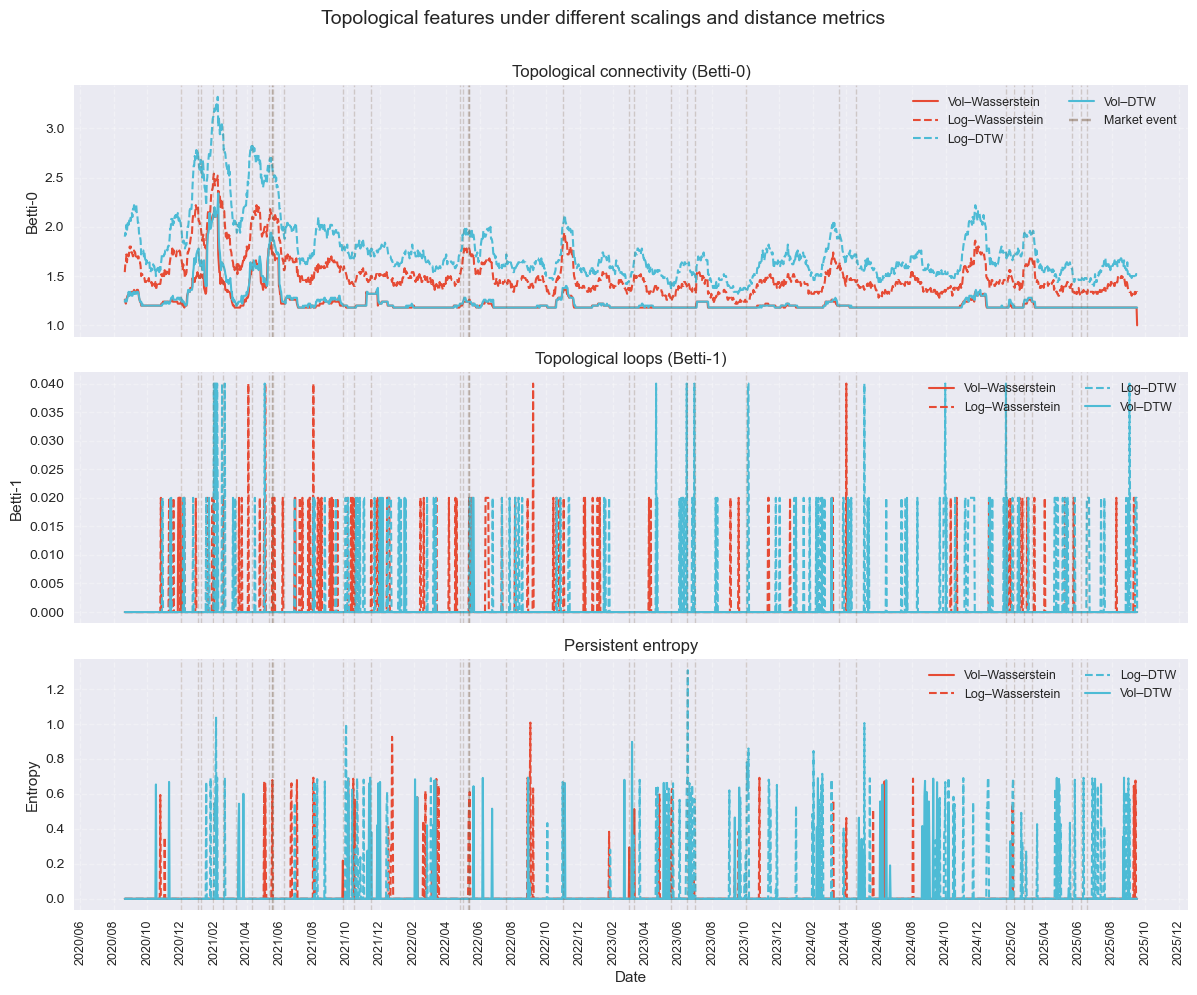

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# === 1. 读取新合并的 TDA 结果 ===
path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_merged_new.csv"
df = pd.read_csv(path, parse_dates=["date"])

x = df["date"]

# === 2. 创建画布 ===
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 配色 + 线型
color_wass = "#E64B35"     # Wasserstein 系列橙红
color_dtw  = "#4DBBD5"     # DTW 系列蓝绿

style_vol = "-"            # vol：实线
style_log = "--"           # log：虚线
lw = 1.5


# ---------- 3. Betti-0 ----------
ax = axes[0]
ax.plot(x, df["vol_wass_betti0"], color=color_wass, linestyle=style_vol,  lw=lw, label="Vol–Wasserstein")
ax.plot(x, df["log_wass_betti0"], color=color_wass, linestyle=style_log,  lw=lw, label="Log–Wasserstein")
ax.plot(x, df["log_dtw_betti0"],  color=color_dtw,  linestyle=style_log,  lw=lw, label="Log–DTW")
ax.plot(x, df["vol_dtw_betti0"],  color=color_dtw,  linestyle=style_vol,  lw=lw, label="Vol–DTW")

ax.set_title("Topological connectivity (Betti-0)", fontsize=12)
ax.set_ylabel("Betti-0", fontsize=11)
ax.grid(alpha=0.3, linestyle="--")
ax.legend(frameon=False, fontsize=9, ncol=2)


# ---------- 4. Betti-1 ----------
ax = axes[1]
ax.plot(x, df["vol_wass_betti1"], color=color_wass, linestyle=style_vol, lw=lw, label="Vol–Wasserstein")
ax.plot(x, df["log_wass_betti1"], color=color_wass, linestyle=style_log, lw=lw, label="Log–Wasserstein")
ax.plot(x, df["log_dtw_betti1"],  color=color_dtw,  linestyle=style_log, lw=lw, label="Log–DTW")
ax.plot(x, df["vol_dtw_betti1"],  color=color_dtw,  linestyle=style_vol, lw=lw, label="Vol–DTW")

ax.set_title("Topological loops (Betti-1)", fontsize=12)
ax.set_ylabel("Betti-1", fontsize=11)
ax.grid(alpha=0.3, linestyle="--")
ax.legend(frameon=False, fontsize=9, ncol=2)


# ---------- 5. Entropy ----------
ax = axes[2]
ax.plot(x, df["vol_wass_entropy"], color=color_wass, linestyle=style_vol, lw=lw, label="Vol–Wasserstein")
ax.plot(x, df["log_wass_entropy"], color=color_wass, linestyle=style_log, lw=lw, label="Log–Wasserstein")
ax.plot(x, df["log_dtw_entropy"],  color=color_dtw,  linestyle=style_log, lw=lw, label="Log–DTW")
ax.plot(x, df["vol_dtw_entropy"],  color=color_dtw,  linestyle=style_vol, lw=lw, label="Vol–DTW")

ax.set_title("Persistent entropy", fontsize=12)
ax.set_ylabel("Entropy", fontsize=11)
ax.set_xlabel("Date", fontsize=11)
ax.grid(alpha=0.3, linestyle="--")
ax.legend(frameon=False, fontsize=9, ncol=2)


# ---------- 6. 添加市场事件 ----------
events = pd.to_datetime([
    "2020-12-01","2021-01-02","2021-01-07","2021-01-29","2021-02-16","2021-03-13",
    "2021-04-10","2021-05-12","2021-05-17","2021-05-18","2021-05-19","2021-06-09",
    "2021-09-24","2021-10-15","2021-11-15",
    "2022-04-27","2022-05-01","2022-05-11","2022-05-12","2022-05-13","2022-07-20",
    "2022-11-01","2023-03-01","2023-03-10","2023-05-17","2023-06-16","2023-07-01",
    "2023-10-01","2024-03-19","2024-04-20","2025-01-20","2025-02-03","2025-02-21",
    "2025-03-07","2025-05-20","2025-06-05","2025-06-17"
])

event_color = "#7E6148"

for e in events:
    if x.min() <= e <= x.max():
        for ax in axes:
            ax.axvline(e, color=event_color, linestyle="--", alpha=0.25, lw=1)

event_legend = Line2D([0], [0], color=event_color, linestyle="--",
                      alpha=0.5, label="Market event")
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles + [event_legend], labels + ["Market event"],
               frameon=False, fontsize=9, ncol=2)


# ---------- 7. 时间轴格式 ----------
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m"))
    ax.grid(True, which="major", axis="x", alpha=0.35)

for ax in axes[:-1]:
    ax.tick_params(axis="x", labelbottom=False)

for lbl in axes[-1].get_xticklabels():
    lbl.set_rotation(90)
    lbl.set_fontsize(9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Topological features under different scalings and distance metrics",
             fontsize=14, y=0.99)

# ---------- 8. 保存图 ----------
save_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig2/Fig2_1_new.png"
fig.savefig(save_path, dpi=900, bbox_inches="tight", transparent=True)

print("图已保存:", save_path)